In [8]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [10]:
torch.cuda.empty_cache()

## Dataset: Dense-Haze

Dense-Haze dataset contains 55 pairs of hazy and non-hazy images. It is used as a benchmark for image dehazing tasks.

Reference: https://data.vision.ee.ethz.ch/cvl/ntire19//dense-haze/

### Data Processing

We create numpy arrays for hazy and non-hazy images while reducing image size to perform faster computations and training.

We also make sure that the images are concatenated in the same order to create (hazy, non-hazy) image pairs.

In [11]:
class dehazer(): 
    
    def __init__(self, IMG_SIZE,LABEL_DIR,LABEL_NAME):

        self.IMG_SIZE = IMG_SIZE
        self.LABEL_DIR = LABEL_DIR
        self.LABEL_NAME = LABEL_NAME
    
        self.training_data=[]
    
    def make_training_data(self):
        
        NUM_IMAGES = len(os.listdir(self.LABEL_DIR))
        
        for f in tqdm(range(1, NUM_IMAGES+1)):
            f = "{:02d}".format(f) + '_' + self.LABEL_NAME + '.png'
            path=os.path.join(self.LABEL_DIR,f)
            img=cv2.imread(path)
            img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
            self.training_data.append(np.array(img))

            
        np.save(f'{self.LABEL_NAME}.npy',self.training_data)

In [12]:
REBUILD_DATA=True
        
IMG_SIZE=256
gt_dir='D:\Minor Project\Dense_Haze_NTIRE19 (1)\GT' 
hazy_dir='D:\Minor Project\Dense_Haze_NTIRE19 (1)\hazy' 
    
if (REBUILD_DATA):
    dehazing=dehazer(IMG_SIZE, gt_dir, 'GT')
    dehazing.make_training_data()
    
    dehazing=dehazer(IMG_SIZE, hazy_dir, 'hazy')
    dehazing.make_training_data()

100%|██████████| 55/55 [00:02<00:00, 26.60it/s]


In [13]:
patch = np.load('GT.npy',allow_pickle=True)
mask = np.load('hazy.npy',allow_pickle=True)

len(patch), len(mask)

(55, 55)

In [14]:
patch.shape, mask.shape

((55, 256, 256, 3), (55, 256, 256, 3))

### Visualizing Data 
Let's look at a few pairs of hazy and non-hazy images.

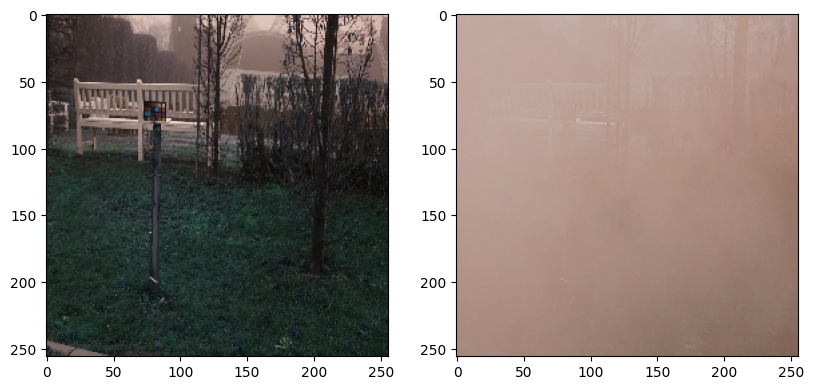

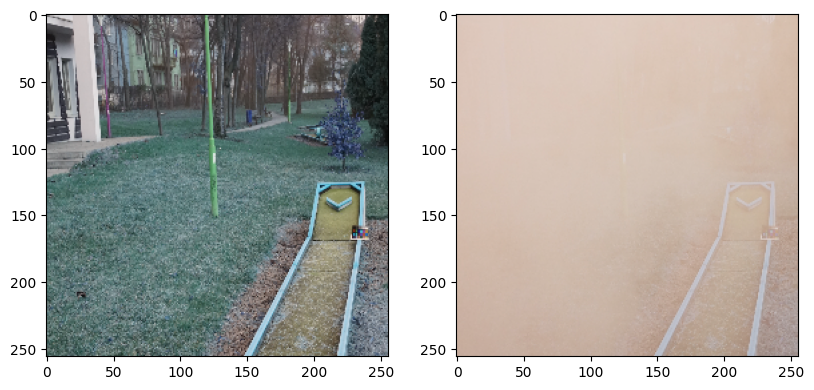

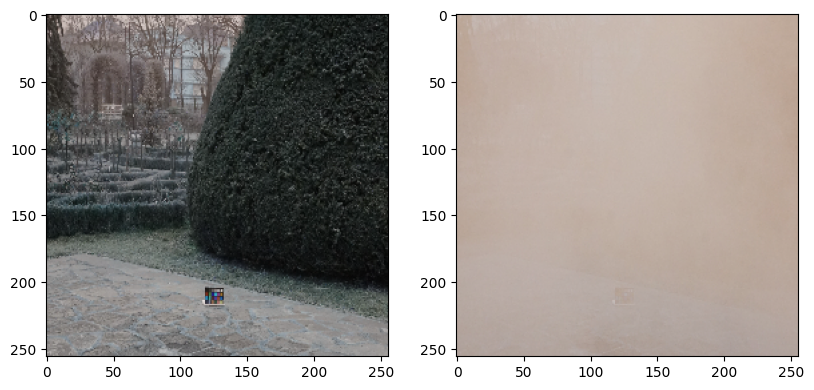

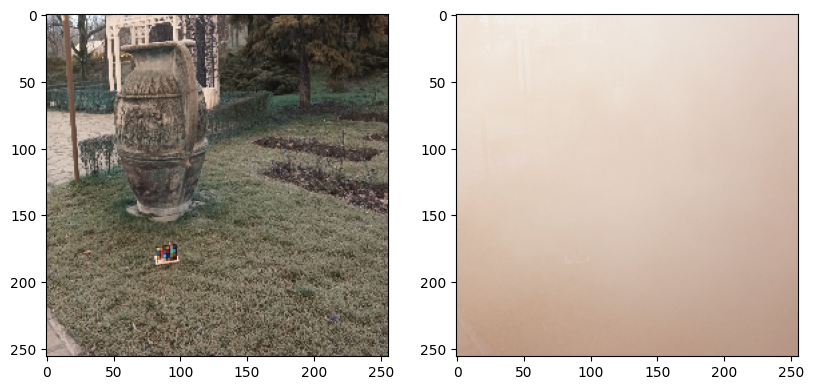

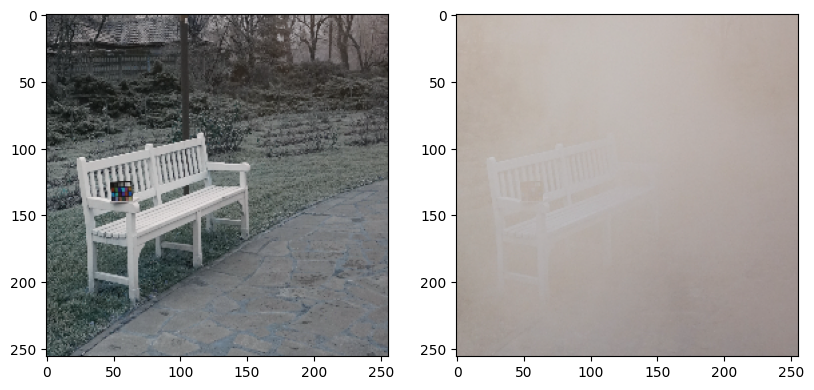

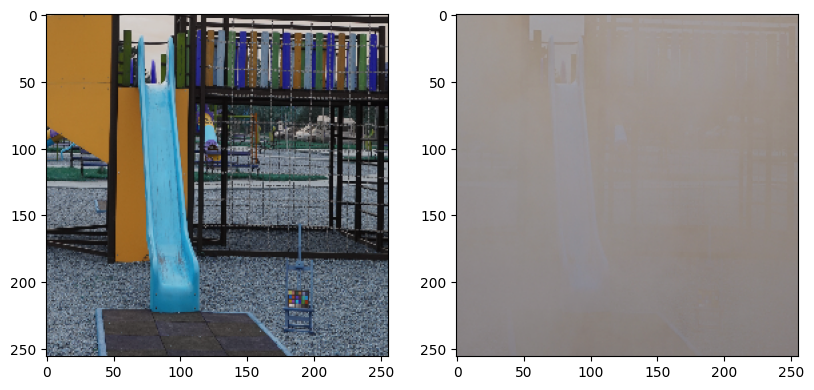

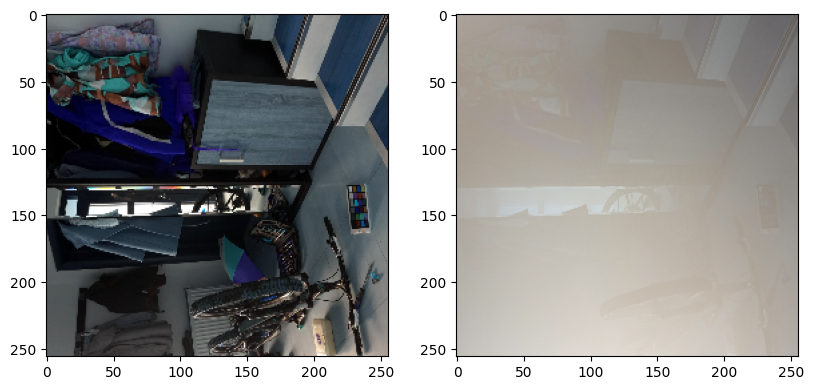

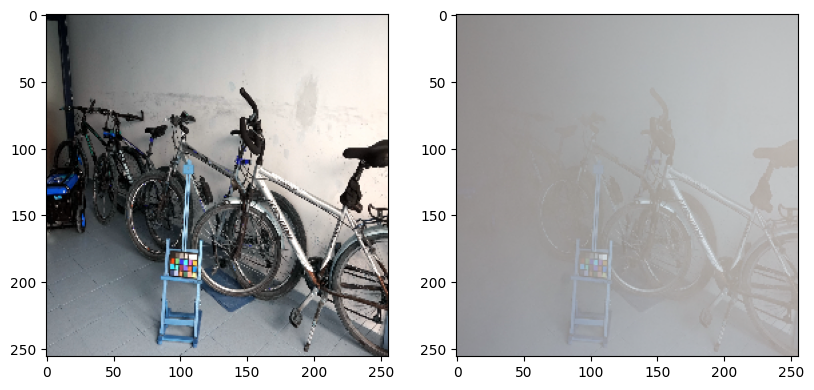

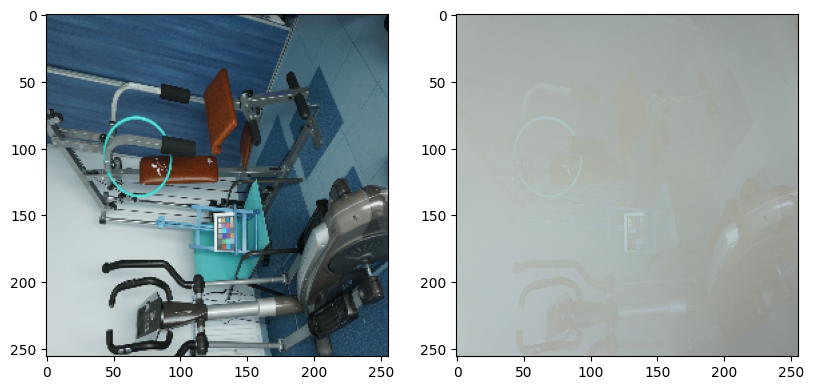

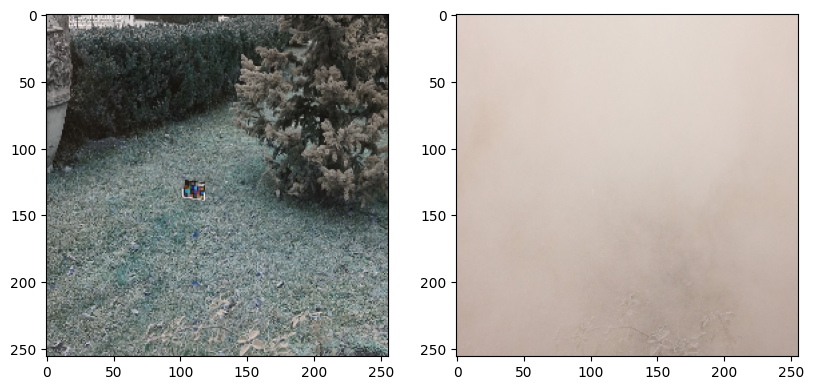

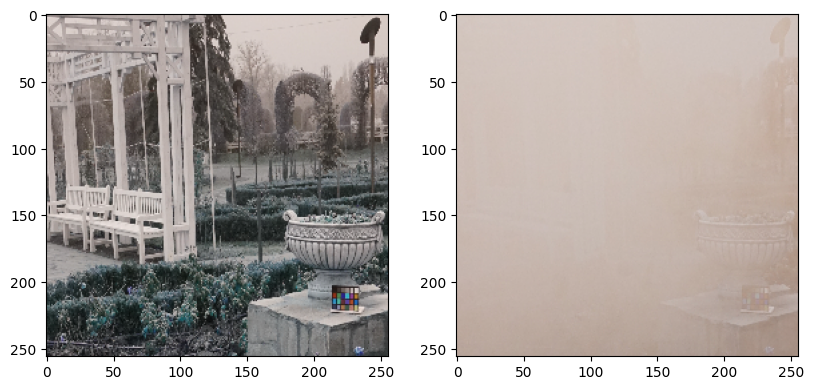

In [15]:
for i in range(0,len(patch),5):
    
    fig=plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(131)
    plt.imshow(patch[i])
    
    ax = plt.subplot(132)
    plt.imshow(mask[i])
    plt.show()

Since the number of images are fairly less (55 in total), we will train it on complete data.

As the number of images are less, we will train keeping a batch size of 1 i.e. **Stochastic Gradient Descent**. The learning might be noisy and it might take longer to train. And so, we will keep the learning rate fairly low and train it on sufficiently large number of epochs.

### MODEL HYPERPARAMETERS

In [16]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.0005

In [17]:
patch_loader = torch.utils.data.DataLoader(dataset=patch,batch_size=batch_size,shuffle=False)

for data in patch_loader:
    print(data.size())
    print(type(data))
    break

torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [18]:
X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

X_orig=X_orig/255
X_hazy=X_hazy/255

C:\Users\Hp\AppData\Local\Temp\ipykernel_14504\724504452.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  X_orig=torch.Tensor([patch[i] for i in range(len(patch))])


In [19]:
print('X_orig: ',X_orig.size())

X_orig_T=np.transpose(X_orig,(0,3,1,2))
X_hazy_T=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_T.shape)

X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_hazy_flat=X_hazy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([55, 256, 256, 3])
X_orig_T:  torch.Size([55, 3, 256, 256])
X_orig_flat:  torch.Size([165, 1, 256, 256])


### Model Architecture: Encoder-Decoder 

Think about the basic difference between machine learning and deep learning. In the former, it's the data scientist/model maker who builds the features which are then passed on to the model. However, in the latter, we delegate the task of creating features as well to the machine apart from learning the patterns in data.

So basically, any deep learning problem can be broadly thought of as:

<code>Input (Tabular, Image, Text etc.) -> Encoder for converting input to numerical representations -> Learning -> Prediction -> Decoder for converting predictions to original form -> Output (Tabular, Image, Text etc.)</code>

However, it's possible that there might be a few steps that are not involved in the above pipeline. For example - if your data is purely numeric, you might not have to encode and decode it, but for unstructured input like images, text or others, you will have to. This is the basic idea behind Encoder-Decoder Architecture.

Consider a machine translation problem of translating sentences from English to French. Here, the encoder function maps the input space (English text) to a latent space, followed by a decoder function that maps the latent space to a different target space (French text). 

**In our case, the input space is hazy images and the output space is non-hazy/ground-truth images.**

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [21]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [22]:
# Check output of encoder-decoder

train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


### Loss function and Optimizer

**Loss Function:** Mean Squared Error (MSE) Loss

As our objective is to minimize the difference between decoder output (dehazed image) and ground-truth, we aim to minimize the MSE between two images.
    
**Optimizer**: Adam (Adaptive Moment Estimation), commonly seen as combination of Adagrad and Momentum

1. Adaptive learning rate for different parameters
2. Faster converging through Momentum, which results in accelerated gradients 
    

In [23]:
# In order to use multi parameters with one optimizer, concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):
    
    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    X_orig_iter2=X_orig_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)
    X_hazy_iter2=X_hazy_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter2,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter2,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()
        
        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)
        
        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()

    losses.append(loss)
    
torch.save([encoder,decoder],'dehaze_autoencoder.pkl')

  0%|          | 0/1000 [00:06<?, ?it/s]


KeyboardInterrupt: 

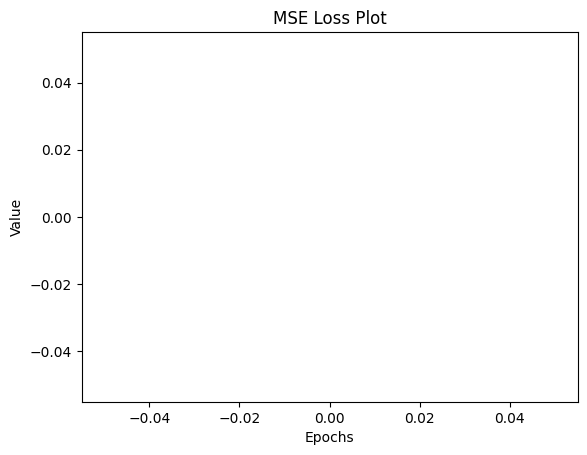

In [24]:
losses = torch.tensor(losses).cpu().numpy()
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(losses)
plt.show()

In [29]:
model = torch.load('dehaze_autoencoder.pkl')
encoder = model[0]
decoder = model[1]

In [20]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|██████████| 165/165 [00:04<00:00, 38.94it/s]


In [21]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([165, 1, 1, 256, 256])
torch.Size([165, 1, 256, 256])
torch.Size([55, 3, 256, 256])
torch.Size([55, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


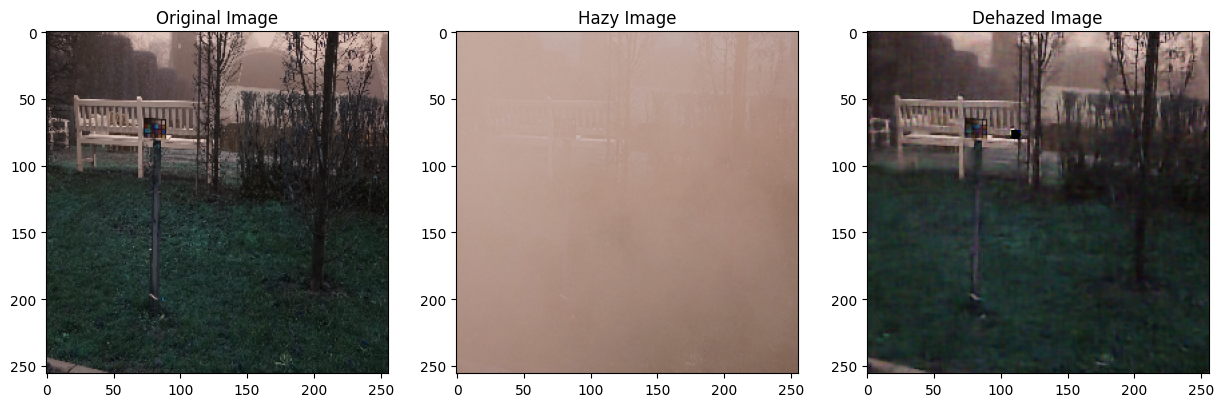

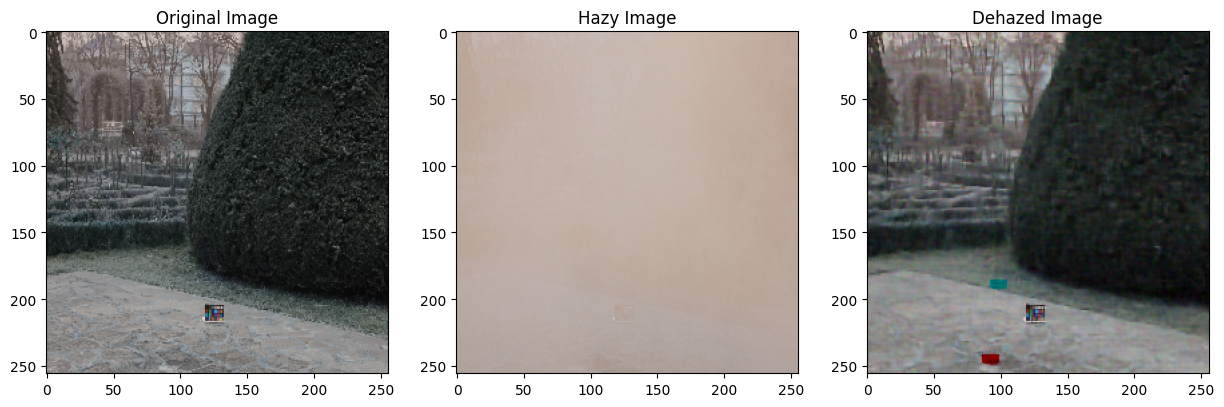

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


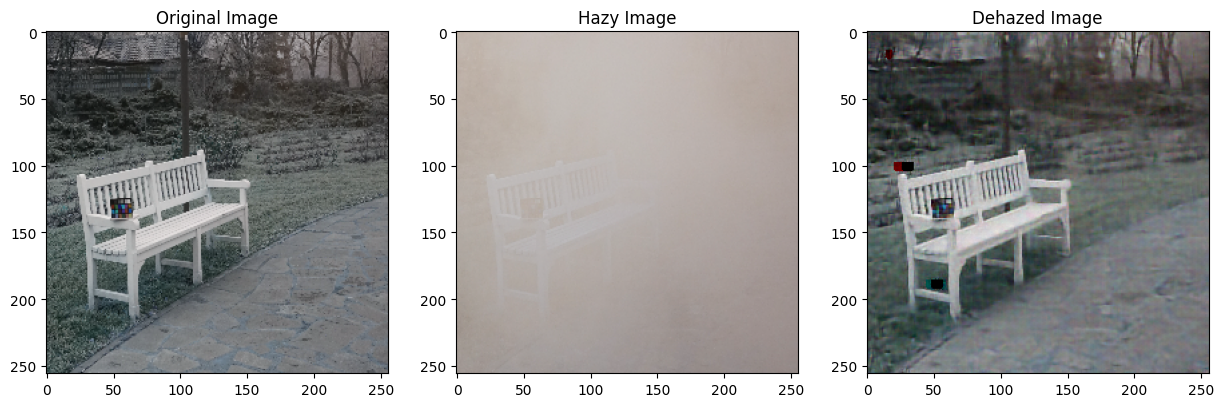

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


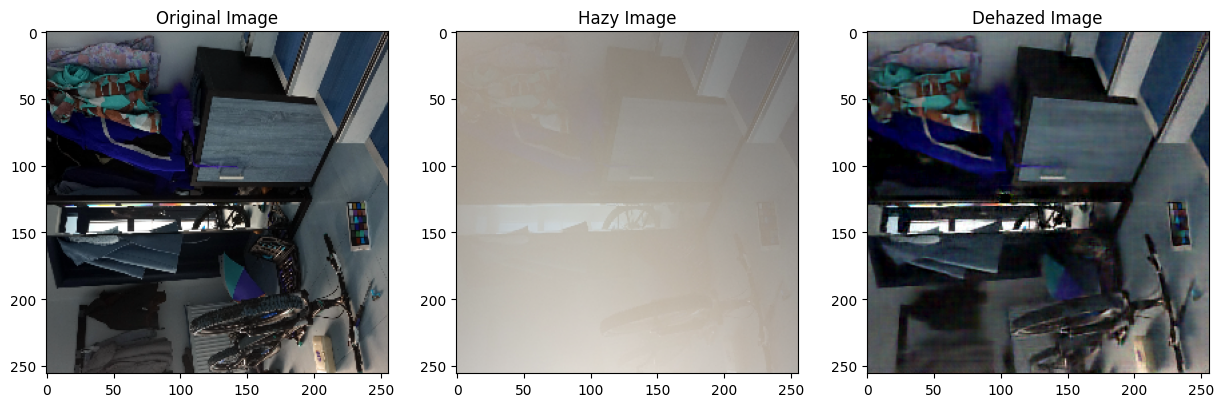

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


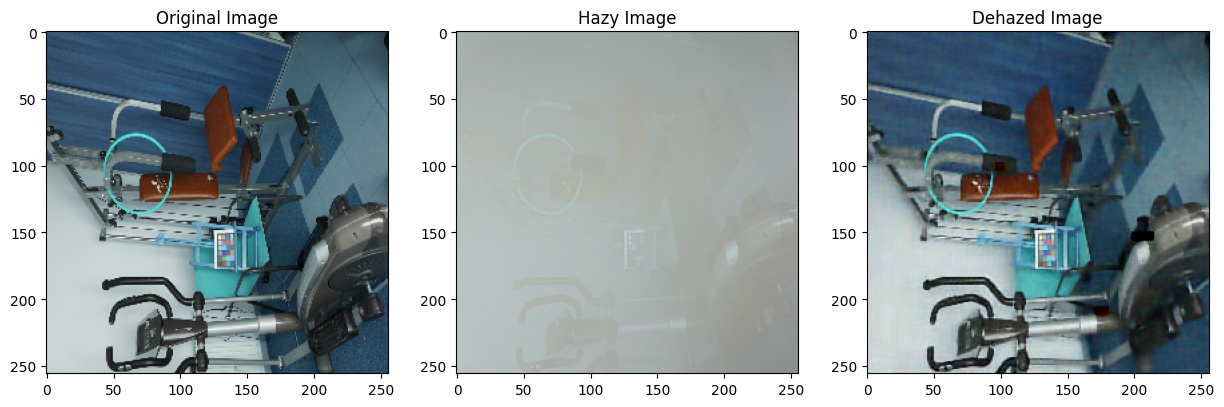

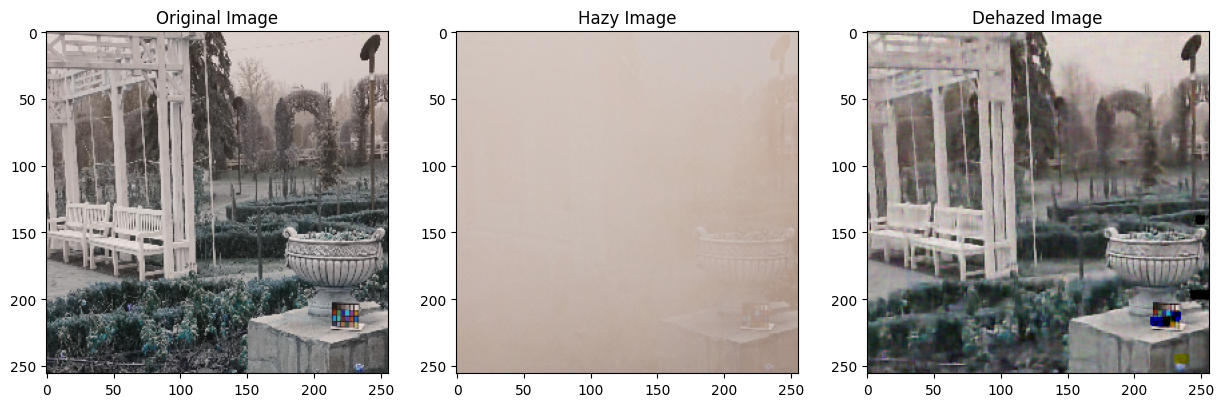

In [22]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])
    
    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

### EVALUATION METRICS

### PSNR (Peak signal-to-noise ratio)

It is an expression for the ratio between maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. It is usually expressed in terms of logarithmic decibel scale, due to its wide dynamic range. It does not have a range. **The higher it is, the better.**

### Structural Similarity (SSIM) Index. 

SSIM is used for measuring the similarity between two images. The SSIM Index is a method for predicting the perceived quality of digital television and cinematic pictures, as well as other kinds of digital images and videos. It is a full reference metric, which means that the measurement or prediction of image quality is based
on an initial uncompressed or distortion-free image as reference. It ranges between -1 to 1 and SSIM equals 1 only when the images are identical. **The closer to 1, the better.**

In [23]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

(55, 256, 256, 3)
(55, 256, 256, 3)


In [24]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

mean_psnr:
25.4684691475105


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# Load the saved models
model = torch.load('dehaze_autoencoder.pkl')
encoder = model[0]
decoder = model[1]

# Define any necessary preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size of the model
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# Load the custom hazed image
custom_image_path = r"C:\Users\Hp\Downloads\img2.jpg"
custom_image = Image.open(custom_image_path).convert('L')  # Convert to grayscale

# Apply preprocessing to the image
input_image = transform(custom_image).unsqueeze(0)  # Add batch dimension

# Move the input image to GPU if available
if torch.cuda.is_available():
    input_image = input_image.cuda()

# Pass the input image through the encoder
encoded_image = encoder(input_image)

# Pass the encoded image through the decoder
output_image = decoder(encoded_image
                       )

# Convert the output tensor to a PIL image
output_image = transforms.ToPILImage()(output_image.squeeze(0).cpu().detach())

# Save or display the output image
output_image.save('output_unhazed_image.jpg')
output_image.show()


c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: Can't get attribute 'Encoder' on <module '__main__'>